In [1]:
from tqdm import tqdm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx
import geopandas as gpd

In [2]:
## Loading network data:

G = ox.load_graphml('graphCM.graphml')

In [3]:
### getting Graph as a geodataframe:

gdf_nodes_cm, gdf_edges_cm = ox.graph_to_gdfs(G)
gdf_edges_cm.head(1)

,,,osmid,ref,name,highway,oneway,reversed,length,geometry,betweenness,closeness,degree,bridge,lanes,maxspeed,junction,access,width,tunnel
u,v,key,,,,,,,,,,,,,,,,,,
165523158,165581108,0,16262619,CA 192,Casitas Pass Road,secondary,False,True,4837.37,"LINESTRING (-119.46292 34.39098, -119.46304 34...",0.0070603760066333555,0.02893261166613099,0.0015600624024961,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
gdf_edges_cm.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
projected_df = gdf_edges_cm.to_crs(26945)
projected_df.head(1)

,,,osmid,ref,name,highway,oneway,reversed,length,geometry,betweenness,closeness,degree,bridge,lanes,maxspeed,junction,access,width,tunnel
u,v,key,,,,,,,,,,,,,,,,,,
165523158,165581108,0,16262619,CA 192,Casitas Pass Road,secondary,False,True,4837.37,"LINESTRING (1865484.015 599811.069, 1865472.92...",0.0070603760066333555,0.02893261166613099,0.0015600624024961,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
projected_df.crs

<Derived Projected CRS: EPSG:26945>
Name: NAD83 / California zone 5
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: United States (USA) - California - counties Kern; Los Angeles; San Bernardino; San Luis Obispo; Santa Barbara; Ventura.
- bounds: (-121.42, 32.76, -114.12, 35.81)
Coordinate Operation:
- name: SPCS83 California zone 5 (meters)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [7]:
## Loading trajectories:

with open('processed_trajs.pkl', 'rb') as f:
    trajs = pickle.load(f)

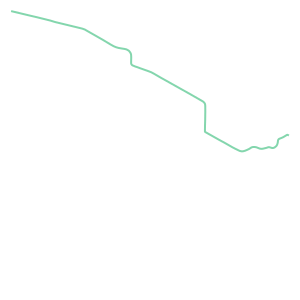

In [13]:
projected_df.iloc[0,7]

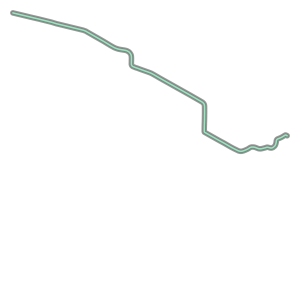

In [26]:
projected_df.iloc[0,7].buffer(25)

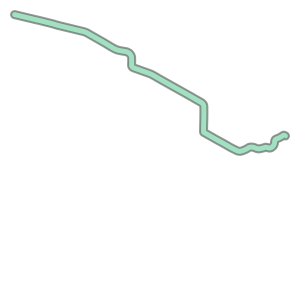

In [27]:
projected_df.iloc[0,7].buffer(50)

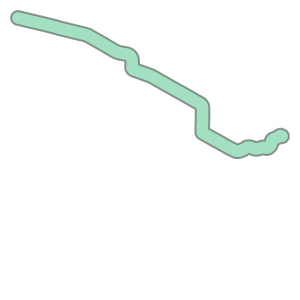

In [25]:
projected_df.iloc[0,7].buffer(100)

In [8]:
## Create buffer around each road segment:

def buffer (df,geometry,radius):
    new_column = 'buffer'+'_'+str(radius)
    df[new_column] = df[str(geometry)].buffer(radius)
    return print('Successfully Done!')

In [9]:
df_buffer = projected_df.copy()

In [10]:
## numbers below are in meters:

buffer(df_buffer,'geometry',5)
buffer(df_buffer,'geometry',10)
buffer(df_buffer,'geometry',15)

Successfully Done!
Successfully Done!
Successfully Done!


In [11]:
### converting "wkt" to "geometry" and creating a geodataframe:

def geo_dataframe (df,wkt_clmn):
    df['traj_geometry'] = gpd.GeoSeries.from_wkt(df[wkt_clmn])
    gdf = gpd.GeoDataFrame(df, geometry='traj_geometry',crs='EPSG:4326')
    gdf_projected = gdf.to_crs(26945)
    return gdf_projected

## how to use it?
## geo_dataframe (df,'wkt_clmn')

In [12]:
all_gdf_trajs = []
for i in tqdm(range(0,len(trajs))):
    days = trajs[i][0]
    daily_trajs = trajs[i][1]
    gdf_trajs = geo_dataframe (daily_trajs,'trajectory_wkt')
    all_gdf_trajs.append([days,gdf_trajs])
    

100%|██████████| 184/184 [00:25<00:00,  7.34it/s]


In [13]:
for i in tqdm(range(123,153)):
    days = all_gdf_trajs[i][0]
    print(i,days)

100%|██████████| 30/30 [00:00<00:00, 112750.11it/s]

123 20191101
124 20191102
125 20191103
126 20191104
127 20191105
128 20191106
129 20191107
130 20191108
131 20191109
132 20191110
133 20191111
134 20191112
135 20191113
136 20191114
137 20191115
138 20191116
139 20191117
140 20191118
141 20191119
142 20191120
143 20191121
144 20191122
145 20191123
146 20191124
147 20191125
148 20191126
149 20191127
150 20191128
151 20191129
152 20191130


In [14]:
id_clmn_road = df_buffer.columns.get_loc('buffer_10')
all_days = []
# Pre-calculate bounds and intersections outside the loop
df_buffer_bounds = df_buffer.iloc[:, id_clmn_road].bounds

for i in tqdm(range(123,153)):
    days = all_gdf_trajs[i][0]
    gdf_daily_trajs = all_gdf_trajs[i][1]
    df_buffer[str(days)] = 0

   
    sindex = gdf_daily_trajs.sindex


    all_matches = []

    for j in range(len(df_buffer)):
        possible_matches_index = list(sindex.intersection(df_buffer_bounds.iloc[j]))
        possible_matches = gdf_daily_trajs.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(df_buffer.iloc[j, id_clmn_road])]
        all_matches.append([len(precise_matches),precise_matches.speed_kinematic_ms_avg.median()])
        
    df_buffer[str(days)] = all_matches
    
df_buffer.to_pickle('road_agg_10.pkl')    

100%|██████████| 30/30 [09:33<00:00, 19.12s/it]


In [ ]:
#df = pd.read_pickle("road_agg_10.pkl")